# Анализ воронки в игре Quiz Freeze
**ЦЕЛЬ**<br>
Исследовать поведение пользователей в обновлённом приложении (игра Quiz Freeze).

**ЗАДАЧИ**<br>
- Определить, насколько обучение сокращает время прохождения этапов игры.
- Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
- Определить, насколько прозрачен процесс взаимодействия с игрой.

**КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)**<br>
- Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
- Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
- Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

**Под исследование подпадает следующая выборка данных:**<br>
Пользователи, зарегестрированные в 2018 году (с 1 января по 31 декабря 2018 года включительно).

**Исходные данные**<br>
Два файла - таблицы в формате csv:
- таблица event: хранит данные о событиях, которые совершают пользователи;
- таблица purchase: хранит данные об оплатах, которые совершают пользователи.

**Выгрузка и предобработка данных**

Импортируем все необходимые библиотеки

In [140]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import plotly.express as px

 Выгружаем таблицы для дальнейшего исследования и создаем их копии

In [141]:
events = pd.read_csv('C:/mine/IDE/project_3/events.csv', sep=',')
events_df = events.copy()

purchase = pd.read_csv('C:/mine/IDE/project_3/purchase.csv', sep=',')
purchase_df = purchase.copy()

Выводим первые строки DataFrame events_df для визуального ознакомления с данными

In [142]:
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585


Делаем выборку пользователей в DataFrame events_df, зарегестрированых в 2018 году

In [143]:
year_2018 = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') & (events_df['event_type'] == 'registration')
users_2018 = events_df[year_2018]['user_id'].to_list()
events_df= events_df[events_df['user_id'].isin(users_2018)]

Выводим детальную информацию по DataFrame events_df

In [144]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


Из представленной информации видно, что столбец start_time имеет тип данных object, который необходимо изменить на datetime для дальнейшей работы с DataFrame

In [145]:
events_df['start_time'] = pd.to_datetime(events_df['start_time'], dayfirst= True)

Выводим первые строки DataFrame purchase_df для визуального ознакомления с данными

In [146]:
purchase_df.head()

,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


Из представленной информации видно, что столбец event_datetime необходимо изменить на datetime для дальнейшей работы с DataFrame

In [147]:
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], dayfirst= True)

В DataFrame purchase_df делаем выборку пользователей, зарегестрированых в 2018 году

In [148]:
purchase_df= purchase_df[purchase_df['user_id'].isin(users_2018)]

Выводим основные статистические свойства столбцов DataFrame purchase_df

In [149]:
purchase_df.describe()

,id,user_id,amount
count,1600.000000,1600.000000,1600.000000
mean,17645.505625,37752.766250,110.734375
std,462.038637,5822.621784,54.696628
min,16845.000000,27845.000000,25.000000
25%,17245.750000,32815.750000,50.000000
50%,17645.500000,37633.500000,100.000000
75%,18045.250000,43023.000000,150.000000
max,18452.000000,47742.000000,300.000000


## Шаг первый: 
### Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

Для дальнейшей работы объединяем DataFrame events_df и DataFrame purchase_df в единый DataFrame total_events_df

In [150]:
# Перед объединением в DataFrame purchase_df добавляем столбец event_type с обозначением purchase
purchase_df['event_type'] = 'purchase'

# перед объединением переименновываем столбцы с одинаковыми наименованиями
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

# обьединяем таблицы в общую: total_events_df
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df['start_time'] = pd.to_datetime(total_events_df['start_time'])

# в итоговой таблице производим сброс индексов и сортировку событий по id пользователей и по возрастанию времени
total_events_df = total_events_df.reset_index(drop=True).sort_values(['user_id','start_time'])

# выводим первые строки итоговой таблицы total_events_df
total_events_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
12,80320.0,tutorial_start,NaN,2018-01-01 17:47:40,31508.0,27833,NaN,NaN
13,80321.0,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN


В DataFrame total_events_df в столбце event_type определяем, каким образом отмечается старт и финиш обучения. Для этого выводим перечень уникальных записей указанного столбца

In [151]:
total_events_df['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

Таким образом, необходимо выделить из всех пользователей две группы:
1) те, кто прошёл обучение (в столбце event_type у них присутствует запись tutorial_finish), назовем их *tutorial_finish*
2) те, кто не начинал обучене (в столбце event_type у них отсутствует запись tutorial_start), назовем их *no_tutorial*

Также существует третья группа пользователей - те, кто начал, но не закончил обучение (в столбце event_type у них есть запись tutorial_start, но нет записи tutorial_finish), обозначим их как *tutorial_start*

In [152]:
# создаем списки пользователей по категориям
tutorial_finish_users_df = total_events_df[total_events_df['event_type'] == 'tutorial_finish']
tutorial_finish_users = total_events_df[(total_events_df['event_type'] == 'tutorial_finish')]["user_id"].unique()
tutorial_start_users_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_start_users = total_events_df[(total_events_df['event_type'] == 'tutorial_start')]["user_id"].unique()

# определяем функцию для отнесения пользователя к одной из трех категорий
def sort_users(x):
    if x in tutorial_finish_users:
        return 'tutorial_finish'
    elif x in tutorial_start_users:
        return 'tutorial_start'
    else:
        return 'no_tutorial'

# добавляем в DataFrame дополнительный столбец с указанием принадлежности пользователя к одной из трех категорий
total_events_df['user_type'] = total_events_df['user_id'].apply(sort_users)
# удаляем все ненужные столбцы из таблицы
total_events_df = total_events_df[['event_type', 'start_time', 'user_id', 'user_type']]
display(total_events_df)

,event_type,start_time,user_id,user_type
0,registration,2018-01-01 03:48:40,27832,no_tutorial
1,registration,2018-01-01 04:07:25,27833,tutorial_finish
12,tutorial_start,2018-01-01 17:47:40,27833,tutorial_finish
13,tutorial_finish,2018-01-01 17:50:08,27833,tutorial_finish
2,registration,2018-01-01 08:35:10,27834,tutorial_finish
...,...,...,...,...
66954,tutorial_start,2019-01-01 03:26:18,47756,tutorial_finish
66955,tutorial_finish,2019-01-01 03:29:25,47756,tutorial_finish
66957,level_choice,2019-01-01 05:42:11,47756,tutorial_finish
66958,pack_choice,2019-01-01 05:50:36,47756,tutorial_finish


Создаем сводную таблицу (pivot_event_type), в которой содержится информация о старте каждого этапа прохождения игры пользователями (user_id), с отнесением каждого пользователя к одной из трех групп в зависимости от его участия в обучении (no_tutorial, tutorial_start, tutorial_finish).

In [153]:
pivot_event_type = total_events_df.pivot_table(
    values='start_time',
    index=['user_id','user_type'],
    columns='event_type',
    aggfunc='min'
)
display(pivot_event_type)

,event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,user_type,,,,,,
27832,no_tutorial,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
27833,tutorial_finish,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,tutorial_finish,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,tutorial_finish,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,tutorial_finish,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40
...,...,...,...,...,...,...,...
47753,tutorial_finish,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56
47754,no_tutorial,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT
47755,tutorial_finish,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14


Для того, чтобы проверить гипотезу, необходимо определить разницу во времени между событиями игры

Расчет будет производится для двух групп пользователей:
1) те, кто прошел обучение (tutorial_finish)
2) те, кто не начинал обучение (no_tutorial)

В таблице pivot_event_type создаем несколько дополнительных колонок, с указанием расчета разницы во времени между этапами прохождения игры:
1. td_all (разница во времени между этапом покупки 'purchase' и этапом регистрации'registration')
2. td_lev_choice_pack_choice (разница во времени между этапом выбора пакета вопросов  'pack_choice' и этапом выбора уровня сложности 'level_choice')
3. td_pack_choice_purch (разница во времени между этапом оплаты 'purchase' и этапом выбора пакета вопросов 'pack_choice')
4. td_reg_lev_choice (разница во времени между этапом выбора уровня сложности 'level_choice' и этапом регистрации 'registration'

Т.к. у нас существует группа пользователей, которые не проходили обучения, то считаем не целесообразным проводить подсчет разницы во времени между этапами, связанными с обучением.

In [154]:
pivot_event_type['td_all'] = pivot_event_type['purchase'] - pivot_event_type['registration']
pivot_event_type['td_lev_choice_pack_choice'] = pivot_event_type['pack_choice'] - pivot_event_type['level_choice']
pivot_event_type['td_pack_choice_purch'] = pivot_event_type['purchase'] - pivot_event_type['pack_choice']
pivot_event_type['td_reg_lev_choice'] = pivot_event_type['level_choice'] - pivot_event_type['registration']

display(pivot_event_type)

,event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,td_all,td_lev_choice_pack_choice,td_pack_choice_purch,td_reg_lev_choice
user_id,user_type,,,,,,,,,,
27832,no_tutorial,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,NaT
27833,tutorial_finish,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT,NaT,NaT,NaT
27834,tutorial_finish,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT,NaT,NaT,NaT
27835,tutorial_finish,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,NaT,0 days 00:01:21,NaT,0 days 08:42:35
27836,tutorial_finish,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
47753,tutorial_finish,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56,NaT,0 days 00:01:46,NaT,0 days 03:37:24
47754,no_tutorial,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT,NaT,NaT,NaT,NaT
47755,tutorial_finish,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14,NaT,NaT,NaT,0 days 07:49:38


Проведем расчет средненего значения длительности этапов прохождения игры в зависимости от принадлежности пользователя к типу

In [155]:
#Создаем сводную таблицу pivot_user_type_mean с расчетом среднего времени между этапами игры для каждого типа пользователей

pivot_user_type_mean = pivot_event_type.groupby(by ='user_type')[['td_all','td_lev_choice_pack_choice',\
    'td_pack_choice_purch', 'td_reg_lev_choice']].mean()

display(pivot_user_type_mean)

event_type,td_all,td_lev_choice_pack_choice,td_pack_choice_purch,td_reg_lev_choice
user_type,,,,
no_tutorial,4 days 09:06:01.909090909,0 days 00:05:23.824324324,4 days 04:49:33.590909090,0 days 05:15:33.122448979
tutorial_finish,4 days 00:30:03.247408431,0 days 00:05:18.146058732,3 days 17:17:59.641326883,0 days 07:05:36.854819357
tutorial_start,4 days 05:32:53.213740458,0 days 00:05:05.295687885,3 days 21:14:46.908396946,0 days 08:12:57.551816958


Переводим формат данных, полученных в сводных таблицах в числовой для дальнейшей визуализации

In [156]:
pivot_user_type_mean = pivot_user_type_mean.fillna('0')

pivot_user_type_mean['td_all'] = pivot_user_type_mean['td_all']/pd.Timedelta('1 hour')
pivot_user_type_mean['td_lev_choice_pack_choice'] = pivot_user_type_mean['td_lev_choice_pack_choice']/pd.Timedelta('1 hour')
pivot_user_type_mean['td_pack_choice_purch'] = pivot_user_type_mean['td_pack_choice_purch']/pd.Timedelta('1 hour')
pivot_user_type_mean['td_reg_lev_choice'] = pivot_user_type_mean['td_reg_lev_choice']/pd.Timedelta('1 hour')
display(pivot_user_type_mean)


event_type,td_all,td_lev_choice_pack_choice,td_pack_choice_purch,td_reg_lev_choice
user_type,,,,
no_tutorial,105.100530,0.089951,100.825997,5.259201
tutorial_finish,96.500902,0.088374,89.299900,7.093571
tutorial_start,101.548115,0.084804,93.246363,8.215987


Пhиведем таблицу в более удобный для восприятия вид

In [157]:
#Переименуем колонки
pivot_user_type_mean = pivot_user_type_mean.rename(columns = \
    {'td_all':'От старта до покупки', \
        'td_lev_choice_pack_choice':'От выбора уровня до выбора пакета',\
        'td_pack_choice_purch':'От выбора пакета до покупки',\
        'td_reg_lev_choice':'От регистрации до выбора уровня'})

# транспонируем таблицу для наглядности
pivot_user_type_mean = pivot_user_type_mean.transpose()

# Переименуем колонки в транспонированной таблице и выведим ее на экран
pivot_user_type_mean_plot = pivot_user_type_mean.copy()
pivot_user_type_mean_plot = pivot_user_type_mean_plot.rename(columns = \
    {'no_tutorial':'Не проходили обучение', 'tutorial_finish':'Прошли обучение', 'tutorial_start':'Не закончили обучение'})
display(pivot_user_type_mean_plot)

user_type,Не проходили обучение,Прошли обучение,Не закончили обучение
event_type,,,
От старта до покупки,105.100530,96.500902,101.548115
От выбора уровня до выбора пакета,0.089951,0.088374,0.084804
От выбора пакета до покупки,100.825997,89.299900,93.246363
От регистрации до выбора уровня,5.259201,7.093571,8.215987


In [158]:
#Удаляем не интересующую нас группу пользователей
pivot_user_type_mean_plot = pivot_user_type_mean_plot.drop(columns = 'Не закончили обучение')

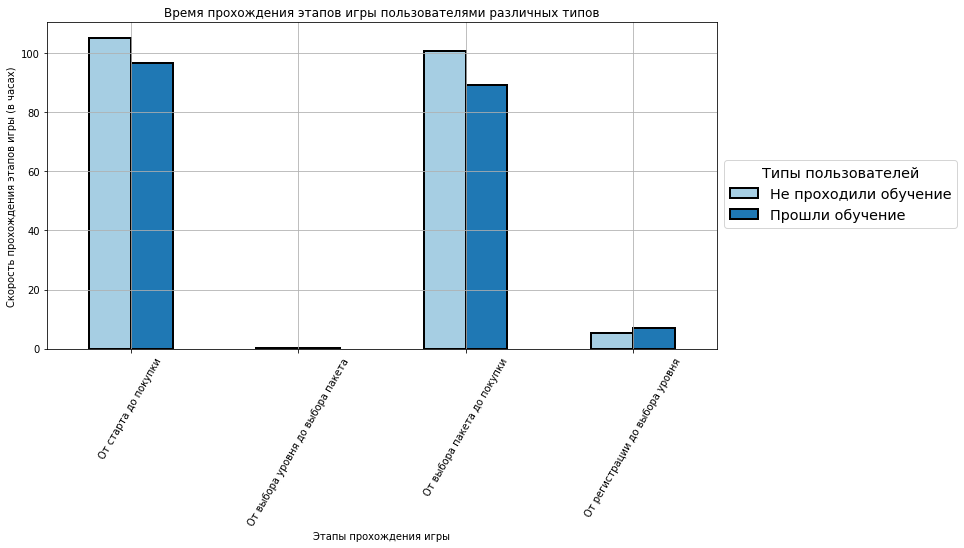

In [159]:
col_map = plt.get_cmap('Paired')

pivot_user_type_mean_plot.plot(
    kind = 'bar',
    grid = True,
    figsize = (12,6),
    rot=60,
    color=col_map.colors,
    edgecolor='k', linewidth=2
   )
plt.title('Время прохождения этапов игры пользователями различных типов')
plt.xlabel('Этапы прохождения игры')
plt.ylabel('Скорость прохождения этапов игры (в часах)')
plt.legend(title = 'Типы пользователей', bbox_to_anchor=(1, 0.6), fontsize = 'x-large', title_fontsize = 'x-large');


**Выводы по первой гипотезе:**<br>
- Пользователи, прошедшие обучение, в среднем на 9,4 часа быстрее проходят от этапа регистрации до этапа покупки платного пакета
- Пользователи, прошедшие обучение, в среднем на 11 часов быстрее переходят от этапа  выбора пакета вопросов до этапа покупки платного пакета
- Однако, пользователи, не проходившие обучение, в среднем на 1,8 часа быстрее переходят от этапа регистрации до этапа выбора уровня сложности вопросов
- Разница перехода от выбора уровня сложности вопросов до выбора пакета вопросов между двумя рассматриваемями группами незначительна (в среднем составляем около 5 секунд)

Для двух выделенных групп пользователей (проходивших и не проходивших обучение) наглядно видно разницу во времени при переходе на разные этапы игры.
Особенно важно отметить, что факт прохождения обучения ускоряет покупку платного пакета вопросов.

Таким образом, на первом этапе выявлено влияние обучения на скорость прохождения этапов игры.

## Шаг второй:
### Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

Для проверки второй гипотезы в DataFrame total_events_df необходимо оставить только те события (event_type), которые связаны с обучением и оплатой пакета вопросов: tutorial_start, tutorial_finish, purchase.
Для этих целей создаем копию указанного выше DataFrame - total_events_df_hip2

In [160]:
total_events_df_hip2 = total_events_df.copy()
total_events_df_hip2 = total_events_df_hip2[(total_events_df_hip2['event_type'] == 'tutorial_start') |\
    (total_events_df_hip2['event_type'] == 'tutorial_finish') | (total_events_df_hip2['event_type'] =='purchase')]

total_events_df_hip2 = total_events_df_hip2.drop(columns='user_type')

total_events_df_hip2.head()

,event_type,start_time,user_id
12,tutorial_start,2018-01-01 17:47:40,27833
13,tutorial_finish,2018-01-01 17:50:08,27833
17,tutorial_start,2018-01-01 19:46:11,27834
18,tutorial_finish,2018-01-01 19:48:01,27834
8,tutorial_start,2018-01-01 15:00:51,27835


Создаем сводную таблицу для подсчета того, сколько раз каждый пользователь совершал покупку, начинал и заканчивал обучение

In [161]:
pivot_hip2 = total_events_df_hip2.pivot_table(
    values='start_time',
    index='user_id',
    columns='event_type',
    aggfunc='count'
)
pivot_hip2 = pivot_hip2.fillna(0)
pivot_hip2.head()

event_type,purchase,tutorial_finish,tutorial_start
user_id,,,
27833,0.0,1.0,1.0
27834,0.0,1.0,1.0
27835,0.0,1.0,1.0
27836,0.0,1.0,2.0
27839,0.0,1.0,1.0


Проверим существующие варианты: сколько раз пользователи совершали покупку, сколько раз начинали и заканчивали обучение

In [162]:
purch = pivot_hip2['purchase'].unique()
t_start = pivot_hip2['tutorial_start'].unique()
t_finish = pivot_hip2['tutorial_finish'].unique()
print(numpy.sort(purch))
print(numpy.sort(t_start))
print(numpy.sort(t_finish))

[0. 1.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Из полученных результатов видно, что пользователи не совершали более одной покупки, а вот события начала и окончания обучения происходило от 0 до 9 раз.

В связи с этим осуществляем деление пользователей на группы следующим образом:
1) разделяем пользователей по признаку наличия события старта обчения: выделяем категории в зависимости от того, сколько раз пользователь начинал обучение: start_0, start_1, start_2, start_3, start_4, start_5, start_6, start_7, start_8, start_9.
2) разделяем пользователей по признаку наличия события окончания обучения: выделяем категории в зависимости от того, сколько раз пользователь заканчивал обучение: finish_0, finish_1, finish_2, finish_3, finish_4, finish_5, finish_6, finish_7, finish_8, finish_9.


In [163]:
# определяем функцию для отнесения пользователя к одной из категорий по признаку начала обучения
def start_users(x):
    if x == 0:
        return 'start_0'
    elif x == 1:
        return 'start_1'
    elif x == 2:
        return 'start_2'
    elif x == 3:
        return 'start_3'
    elif x == 4:
        return 'start_4'
    elif x == 5:
        return 'start_5'
    elif x == 6:
        return 'start_6'
    elif x == 7:
        return 'start_7'
    elif x == 8:
        return 'start_8'
    elif x == 9:
        return 'start_9'
    
# определяем функцию для отнесения пользователя к одной из категорий по признаку окончания обучения
def finish_users(x):
    if x == 0:
        return 'finish_0'
    elif x == 1:
        return 'finish_1'
    elif x == 2:
        return 'finish_2'
    elif x == 3:
        return 'finish_3'
    elif x == 4:
        return 'finish_4'
    elif x == 5:
        return 'finish_5'
    elif x == 6:
        return 'finish_6'
    elif x == 7:
        return 'finish_7'
    elif x == 8:
        return 'finish_8'
    elif x == 9:
        return 'finish_9'
    

# добавляем в DataFrame дополнительный столбец с указанием принадлежности пользователя к одной из категорий по признаку начала обучения
pivot_hip2['user_start_type'] = pivot_hip2['tutorial_start'].apply(start_users)

# добавляем в DataFrame дополнительный столбец с указанием принадлежности пользователя к одной из категорий по признаку окончания обучения
pivot_hip2['user_finish_type'] = pivot_hip2['tutorial_finish'].apply(finish_users)

display(pivot_hip2)

event_type,purchase,tutorial_finish,tutorial_start,user_start_type,user_finish_type
user_id,,,,,
27833,0.0,1.0,1.0,start_1,finish_1
27834,0.0,1.0,1.0,start_1,finish_1
27835,0.0,1.0,1.0,start_1,finish_1
27836,0.0,1.0,2.0,start_2,finish_1
27839,0.0,1.0,1.0,start_1,finish_1
...,...,...,...,...,...
47748,0.0,1.0,1.0,start_1,finish_1
47751,0.0,1.0,1.0,start_1,finish_1
47753,0.0,1.0,1.0,start_1,finish_1


Считаем количество пользователей в каждой группе в зависимости от того, сколько раз они начинали обучение

In [164]:
#Перемещаем user_id из индексов в столбцы
pivot_hip2.reset_index(inplace=True)

#Считаем количество пользователей в каждой группе в зависимости от категории
pivot_hip2_start = pivot_hip2.groupby('user_start_type').agg(users = pd.NamedAgg(column='user_id', aggfunc='count'),\
    purch_start_users = pd.NamedAgg(column='purchase', aggfunc='sum'))

#Добавим столбец с коэффициентом конверсии CR
pivot_hip2_start['CR_start'] = pivot_hip2_start['purch_start_users']/pivot_hip2_start['users']*100
pivot_hip2_start.reset_index(inplace=True)
pivot_hip2_start.head(10)

,user_start_type,users,purch_start_users,CR_start
0,start_0,22,22.0,100.000000
1,start_1,9103,1207.0,13.259365
2,start_2,1589,218.0,13.719320
3,start_3,427,51.0,11.943794
4,start_4,221,30.0,13.574661
5,start_5,109,16.0,14.678899
6,start_6,116,14.0,12.068966
7,start_7,94,12.0,12.765957
8,start_8,86,13.0,15.116279
9,start_9,113,17.0,15.044248


Считаем количество пользователей в каждой группе в зависимости от того, сколько раз они закончили обучение

In [165]:
pivot_hip2_finish = pivot_hip2.groupby('user_finish_type').agg(users = pd.NamedAgg(column='user_id', aggfunc='count'),\
    purch_finish_users = pd.NamedAgg(column='purchase', aggfunc='sum'))

#Добавим столбец с коэффициентом конверсии CR
pivot_hip2_finish['CR_finish'] = pivot_hip2_finish['purch_finish_users']/pivot_hip2_finish['users']*100
pivot_hip2_finish.reset_index(inplace=True)
pivot_hip2_finish.head(10)

,user_finish_type,users,purch_finish_users,CR_finish
0,finish_0,1630,153.0,9.386503
1,finish_1,8015,1143.0,14.260761
2,finish_2,1321,182.0,13.777441
3,finish_3,345,44.0,12.753623
4,finish_4,178,19.0,10.674157
5,finish_5,117,19.0,16.239316
6,finish_6,101,15.0,14.851485
7,finish_7,97,15.0,15.463918
8,finish_8,54,6.0,11.111111
9,finish_9,22,4.0,18.181818


Для наглядности сделаем столбчатые диаграммы, отражающие количество пользователей внутри каждой группы в зависимости от количества событий старта и окончания обучения

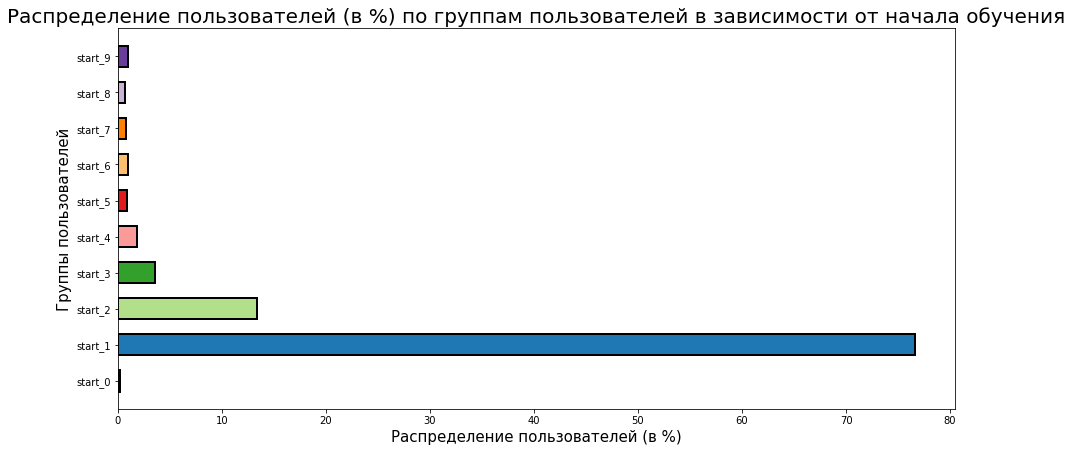

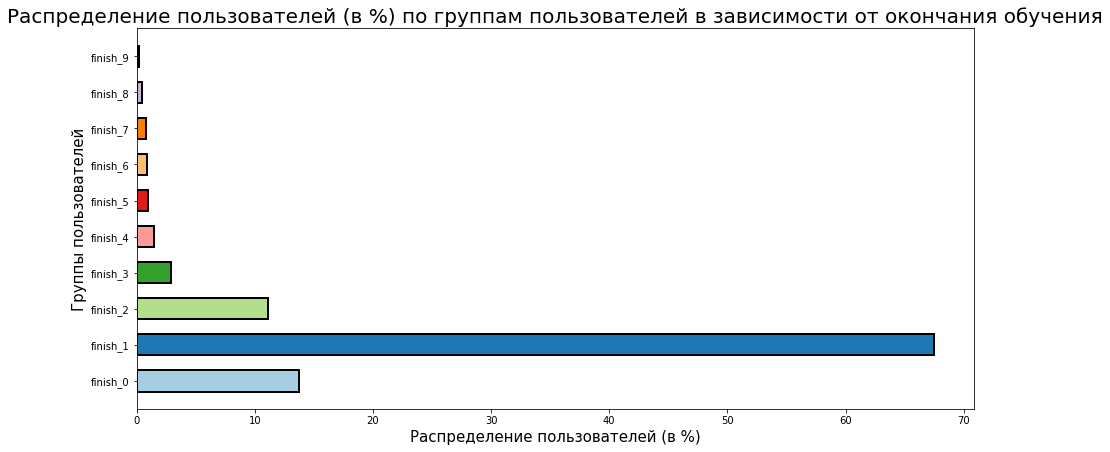

In [166]:
# Готовим датафрейм для визуализации
pivot_hip2_start['users_percent'] = pivot_hip2_start['users']/pivot_hip2_start['users'].sum()*100
groups_s = pivot_hip2_start['user_start_type']
percent_s = pivot_hip2_start['users_percent']

# Задаем параметры фигуры и цветовое решение
plt.figure(figsize=[15, 7])
col_map = plt.get_cmap('Paired')

# Вводим параметры диаграммы
plt.barh(groups_s, percent_s, height=0.6, color=col_map.colors, 
         edgecolor='k', linewidth=2)

# Оформляем заголовки
plt.title('Распределение пользователей (в %) по группам пользователей в зависимости от начала обучения', fontsize=20)
plt.xlabel('Распределение пользователей (в %)', fontsize=15)
plt.ylabel('Группы пользователей', fontsize=15)
plt.show()

# Готовим датафрейм для визуализации
pivot_hip2_finish['users_percent'] = pivot_hip2_finish['users']/pivot_hip2_finish['users'].sum()*100
groups_f = pivot_hip2_finish['user_finish_type']
percent_f = pivot_hip2_finish['users_percent']

# Задаем параметры фигуры и цветовое решение
plt.figure(figsize=[15, 7])
col_map = plt.get_cmap('Paired')

# Вводим параметры диаграммы
plt.barh(groups_f, percent_f, height=0.6, color=col_map.colors, 
         edgecolor='k', linewidth=2)

# Оформляем заголовки
plt.title('Распределение пользователей (в %) по группам пользователей в зависимости от окончания обучения', fontsize=20)
plt.xlabel('Распределение пользователей (в %)', fontsize=15)
plt.ylabel('Группы пользователей', fontsize=15)
plt.show()

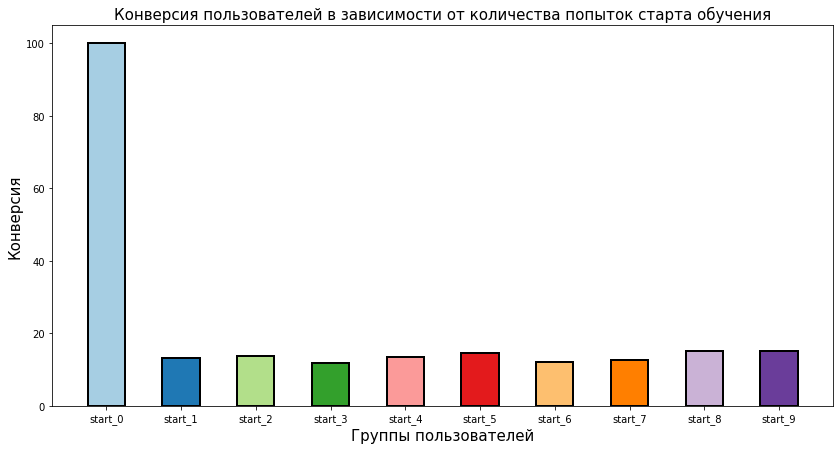

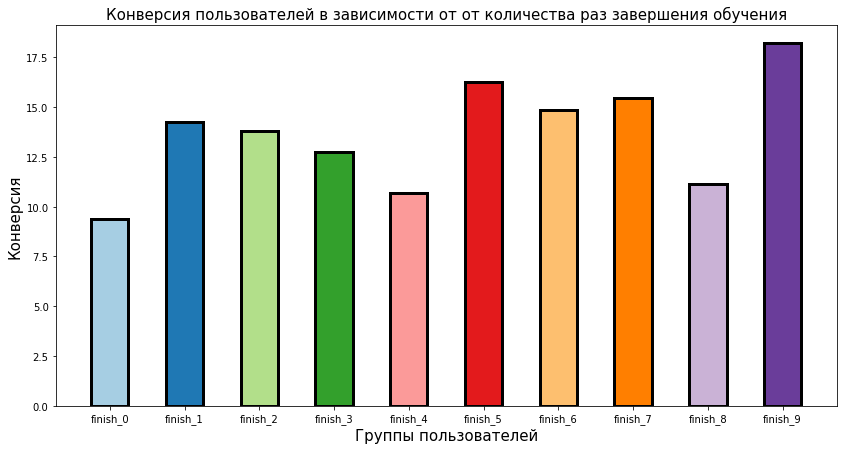

In [167]:
# Задаем фигуру и параметры
plt.figure(figsize=[14, 7])
col_map = plt.get_cmap('Paired')
groups_s = pivot_hip2_start['user_start_type']
cr_s = pivot_hip2_start['CR_start']


# Создаем столбяатую диаграмму
plt.bar(groups_s, cr_s, width=0.5, color=col_map.colors, 
        edgecolor='k', linewidth=2)

# Задаем оформление заголовков
plt.title('Конверсия пользователей в зависимости от количества попыток старта обучения', fontsize=15)
plt.xlabel('Группы пользователей', fontsize=15)
plt.ylabel('Конверсия', fontsize=15)
plt.show()


# Задаем фигуру и параметры
plt.figure(figsize=[14, 7])
col_map = plt.get_cmap('Paired')
groups_f = pivot_hip2_finish['user_finish_type']
cr_f = pivot_hip2_finish['CR_finish']

# Создаем столбяатую диаграмму
plt.bar(groups_f, cr_f, width=0.5, color=col_map.colors, 
        edgecolor='k', linewidth=3)

# Задаем оформление заголовков
plt.title('Конверсия пользователей в зависимости от от количества раз завершения обучения', fontsize=15)
plt.xlabel('Группы пользователей', fontsize=15)
plt.ylabel('Конверсия', fontsize=15)
plt.show()

**Выводы по второй гипотезе:**<br>
***Для групп пользователей в зависимости от количества попыток старта обучения***<br>
- Самой многочисленной является группа пользователей начинавших проходить обучение 1 раз (76,6% пользователей)
- Только 0,2% пользователей не начинали проходить обучение ни разу
- Если исключить группу пользователей со стопроцентной конверсией (пользователи не начинавшие обучение), то остальные группы пользователей имеют незначительные колебания конверсии в пределах 4 процентов. Количество попыток старта обучения не играет значительной роли.
- В связи с тем, что группа со стопроцентной конверсие незначительна (0,2% от общего числа пользователей) при этом конверсия таких пользователей значительно отличается от конверсии остальных групп, полагаю, что результаты данной группы можно отнести к аномалии.
- Максимальная конверсия среди групп пользователей, начинавших обучение составляет 15% (пользователи начинавшие обучение 8 и 9 раз)

***Для групп пользователей в зависимости от количества раз завршения обучения***<br>
- Самой многочисленной является группа пользователей завершивших обучение 1 раз (67,5% пользователей)
- 13,7 % пользователей не завершили обучение ни разу
- Самая малочисленная группа пользователей (0,2%) - это пользователеи завершившие оучения 9 раз
- При разделении пользователей по данному признаку конверсия распределяется более равномерно, без аномалий
- Колебания конверсии по группам в пределах 9% (от 9% до 18% в зависимости от группы)
- Максимальная конверсия составляет 18% (группа пользователей закончивших обучение 9 раз)
- Наблюдается равномерное снижение конверсии для пользователей прошедших обучения от 2 до 4 раз

Таким образом, важным показателем является не только факт начала обучения, но и факт его окончания.
Полагаю, что в рассматриваемом случае наблюдается зависимость оплаты от факта завершения обучения.

## Шаг третий:
### Выяснить, как часто пользователи начинают обучение после выбора уровня сложности.

Для проверки гипотезы необходимо пользователей разделить на 2 группы:
1) те, кто начинают обучение до выбора уровня сложности (tutorial_before_choice)
2) те, кто начинают обучение после выбора уровня сложности (tutorial_after_choice)

In [168]:
#Создаем два датафрейма по событиям level_choice и tutorial_start
level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice']
start_tutorial_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']

#Удаляем ненужные столбцы
level_choice_df = level_choice_df.drop(columns = ['user_type', 'event_type'])
start_tutorial_df = start_tutorial_df.drop(columns = ['user_type', 'event_type'])

#Переименовываем столбцы, содержащие информацию о времени начала события
level_choice_df = level_choice_df.rename(columns = {'start_time':'level_choice_time'})
start_tutorial_df = start_tutorial_df.rename(columns = {'start_time':'start_tutorial_time'})

In [169]:
#Соединяем созданные выше датафреймы
merged_df = level_choice_df.merge(start_tutorial_df, on = 'user_id', how = 'outer')

#Создаем новый столбец time_delta, содержащий информацию о разнице во времени между событием начала обучения и событием выбора уровня сложности
merged_df['time_delta'] = merged_df['start_tutorial_time'] - merged_df['level_choice_time']
merged_df.head()

,level_choice_time,user_id,start_tutorial_time,time_delta
0,2018-01-01 20:37:22,27835,2018-01-01 15:00:51,-1 days +18:23:29
1,2018-01-01 22:37:50,27839,2018-01-01 19:11:36,-1 days +20:33:46
2,2018-01-02 05:18:42,27840,2018-01-02 02:07:07,-1 days +20:48:25
3,2018-01-02 08:46:03,27842,2018-01-02 04:55:11,-1 days +20:09:08
4,2018-01-02 08:46:03,27842,2018-01-02 09:01:51,0 days 00:15:48


In [170]:
#Переводим столбец time_delta в числовой формат(будет содержать разницу во времени между событиями в часах)
merged_df['time_delta'] = merged_df['time_delta']/pd.Timedelta('1 hour')
#Прописываем функцию для разделения пользователей на группы в зависимости от того начинали ли они обучения до или после выбора уровня сложности
def user_group(x):
    if x > 0:
        return 'tutorial_after_choice'
    elif x < 0:
        return 'tutorial_before_choice'
    
#Создаем новый столбец, содержащий информацию о принадлежности к одной из двух групп пользователей
merged_df['user_group'] = merged_df['time_delta'].apply(user_group)

merged_df.head()

,level_choice_time,user_id,start_tutorial_time,time_delta,user_group
0,2018-01-01 20:37:22,27835,2018-01-01 15:00:51,-5.608611,tutorial_before_choice
1,2018-01-01 22:37:50,27839,2018-01-01 19:11:36,-3.437222,tutorial_before_choice
2,2018-01-02 05:18:42,27840,2018-01-02 02:07:07,-3.193056,tutorial_before_choice
3,2018-01-02 08:46:03,27842,2018-01-02 04:55:11,-3.847778,tutorial_before_choice
4,2018-01-02 08:46:03,27842,2018-01-02 09:01:51,0.263333,tutorial_after_choice


In [171]:
#Считаем количество пользователей для каждой группы
merged_df = merged_df.groupby('user_group').agg(users = pd.NamedAgg(column = 'user_id', aggfunc= 'count'))
merged_df.reset_index(inplace=True)
merged_df.head()

,user_group,users
0,tutorial_after_choice,2792
1,tutorial_before_choice,9894


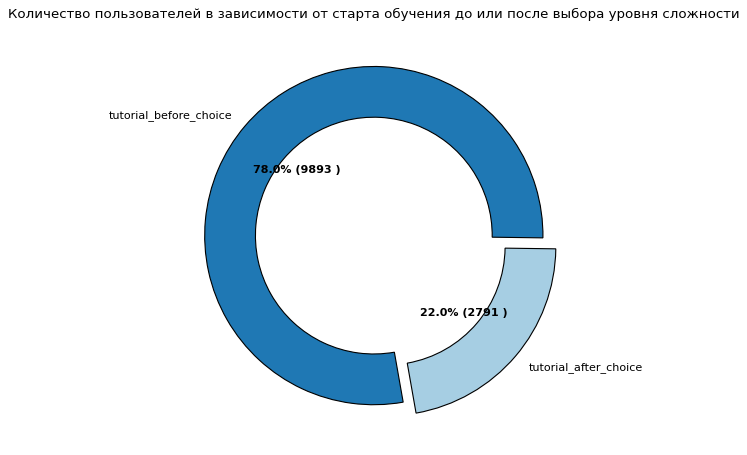

In [172]:
#Визуализируем данные по группам пользователей в зависимости от старта обучения до или после выбора уровня сложности
#Задаем плоскость
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

#Задаем данные для облегчения дальнейшего процесса внутри создания диаграммы
data = merged_df['users']
categories = merged_df['user_group']
explode = [0.1, 0]
colors = plt.get_cmap('Paired')

#Прописываем функцию для абсолютных показателей
def func(pct, allvals):
    absolute = int(pct/100.*numpy.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

#Создаем диаграмму
wedges, texts, autotexts = ax.pie(data, 
                                 autopct= lambda pct: func(pct, data),
                                 textprops=dict(color="black"), 
                                 startangle=-80,
                                 explode=explode,
                                 labels= categories,
                                 wedgeprops={'edgecolor':'black', 'width':0.3},
                                colors = colors.colors                              
                                )



# Оформляем диаграмму
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Количество пользователей в зависимости от старта обучения до или после выбора уровня сложности")
plt.show()

**Выводы по второй гипотезе:**<br>
- Группа пользователей, начавших обучение до выбора уровня сложности, составляет 78% 
- Группа пользователей, начавших обучение после выбора уровня сложности, составляет 22%

# Общие выводы и рекомендации <br>
- Факт прохождения обучения положительно влияет на скорость прохождения этапов игры и ускоряет покупку платного пакета
- Пользователи, завершившие обучение 9 раз имеют самую высокую конверсию
- Более 10% пользователей начавших обучение не завершают его
- Почти каждый пятый пользователь начинает обучение после выбора уровня сложности

Рекомендовано:<br>
- Разработать программу для повышения мотивации пользователей по завершению начатого обучения
- Разработать программу для повышения мотивации пользователей на увеличение количества раз прохождения обучения от начала до конца
- Разработать программу для повышения мотивации пользователей на прохождение обучения на начальном этапе прохождения игры (сразу после регистрации) 